In [13]:
# import packages
import pandas as pd
# import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import datetime
import re
from sklearn.externals import joblib 
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.interpolate import interpn
from collections import defaultdict
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [14]:
# Editor settings
# change used width of browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [15]:
# load data
sales_means =pd.read_csv('../data/sales_means.csv', sep='|').drop(columns=["predicted_promotion"])
scaler = joblib.load('./scaler.pkl') 
df_test = pd.read_csv('../data/orders0206_test.csv', sep='|', parse_dates=['time'])
df_test['date'] = [d.date() for d in df_test['time']]
df_train = pd.read_csv('../data/orders0206_train.csv', sep='|', parse_dates=['time'])
df_train['date'] = [d.date() for d in df_train['time']]
bundles = pd.read_csv('../data/bundles.csv', sep=',')
sales_means = sales_means.join(bundles.set_index("itemID"), on="itemID", how="left")

In [16]:
# needed for evaluation
# actual demand
y = df_test.groupby(by='itemID')['order'].sum().to_dict()

# baseline 1 (average demand of previous 14 days)
y_baseline1 = df_train[df_train['time'] >= '2018-05-19'].groupby(by='itemID')['order'].sum().to_dict()

# baseline 2 (average demand of previous half year)
total_orders = df_train.groupby(by='itemID')['order'].sum().to_dict()
total_observed_days = (df_train['time'].dt.normalize().max() - df_train['time'].dt.normalize().min()).days
y_baseline2 = {item: orders / total_observed_days * 14 for item, orders in total_orders.items()}  # 14-day avg. demand

df_info = pd.read_csv('../data/infos.csv', sep='|', index_col='itemID')
df_items = pd.read_csv('../data/items.csv', sep='|', index_col='itemID')
product_prices = df_info['simulationPrice'].to_dict()

def evaluate_result(y: dict, y_pred: dict):
    monetary_value = 0
    y_pred = defaultdict(int, y_pred)  # return prediction of 0 for items without prediction
    
    for item in set(y_pred).difference(set(y)):
        y[item] = 0  # make sure that all items for which a demand has been predicted are contained in the actual demands
    
    for item, demand in y.items():
        predicted_demand = y_pred[item]
        price = product_prices[item]
        monetary_value += price * min(demand, predicted_demand)
        if predicted_demand > demand:
            monetary_value -= .6 * price * (predicted_demand - demand)
            
    return monetary_value
# perfect result
print(f'Perfect Result: {evaluate_result(y, y):.2f}')

# baseline 1
print(f'Baseline 1: {evaluate_result(y, y_baseline1):.2f}')

# baseline 2
print(f'Baseline 2: {evaluate_result(y, y_baseline2):.2f}')

Perfect Result: 7895975.87
Baseline 1: -3727365.60
Baseline 2: -1672504.21


In [17]:
# slit training, parameter tuning and test data
sales_means.sample(frac=1).reset_index(drop=True)
X_train = sales_means.tail(len(sales_means)-2000)#[(sales_means['weekGroup']<=9)]# & (sales_means['weekGroup']==10)]
X_cv =  sales_means.head(2000)#[sales_means['weekGroup']==10]
X_test = sales_means[sales_means['weekGroup']==11]
Y_train = X_train['count']
Y_cv = X_cv['count']
Y_test = X_test['count']
del X_train['count']
del X_cv['count']
del X_test['count']
del X_train['weekGroup']
del X_cv['weekGroup']
del X_test['weekGroup']
del X_train['itemID']
del X_cv['itemID']

In [18]:
# use best parameters foudn through experiments
bestparams = {'n_estimators': 215,
 'min_samples_split': 10,
 'min_samples_leaf': 8,
 'max_features': 'auto',
 'max_depth': 35,
 'bootstrap': True}

In [19]:
# train model with best parameter combination that was found above
rf = RandomForestRegressor(**bestparams).fit(X_train.fillna(0), Y_train)

<BarContainer object of 65 artists>

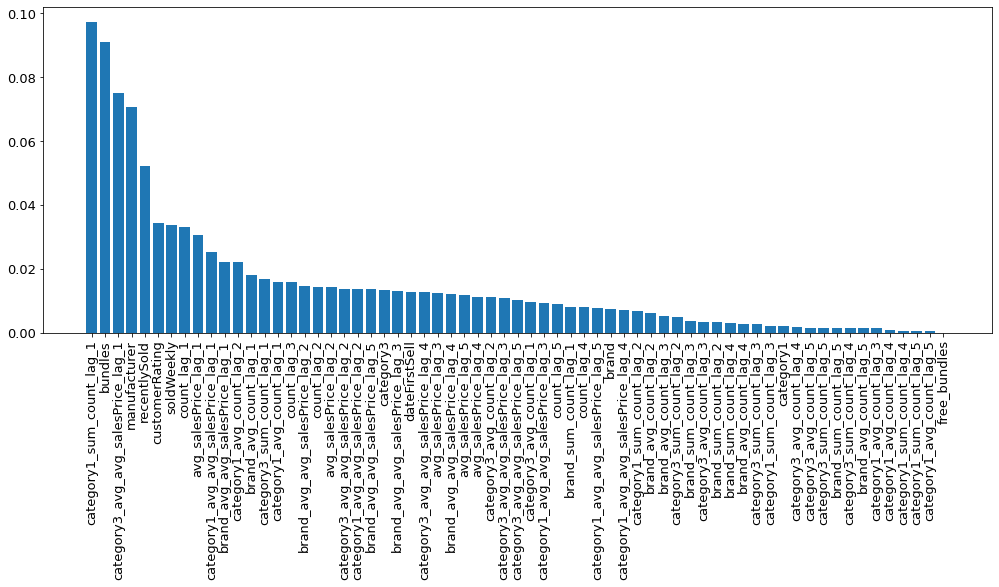

In [20]:
plt.rcParams["figure.figsize"] = (17,6)
plt.rcParams.update({'font.size': 13})
columns = X_train.columns
feature_importances = pd.DataFrame({'columns': columns,'importance':rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance',ascending=False)
plt.xticks(rotation=90)
plt.bar(feature_importances["columns"],feature_importances.importance)# ,x='columns',y='importance')

In [21]:
# apply to unseen data
y_randomforest_all = dict()

for prod in X_test.itemID.unique():
    y_randomforest_all[prod] = int(pd.DataFrame(scaler.inverse_transform(pd.DataFrame(rf.predict(X_test[X_test.itemID == prod].drop(columns=["itemID"]).fillna(0))))).sum().round())


print(f'XGBoost by RF: {evaluate_result(y, y_randomforest_all):.2f}')

XGBoost by RF: 67907.21


In [22]:
pd.DataFrame(y_randomforest_all.items()).rename(columns={0:'itemID', 1:"demandPrediction"}).to_csv('abraca-data_predictions.csv',index=False, sep='|')

In [23]:
joblib.dump(rf, 'randomforest.pkl')

['randomforest.pkl']